# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import math	
	
def preprocessing(file_name, nan_cnt, empty_policy, show_plot = True):

    print(f"filename:{file_name}\nnan_cnt:{nan_cnt}\nempty_policy:{empty_policy}\n")
    
    # load csv file
    df_data = pd.read_csv(file_name)

    # Feature engineering
    isna_dict = dict(df_data.isna().sum())
    isna_keys = list(isna_dict.keys())
    del_column_idx = []
    del_column_names = []
    for idx, cnt in enumerate(isna_dict.values()):
        if cnt >= nan_cnt:
            #print(idx, cnt, isna_keys[idx])
            del_column_idx.append(idx)
            del_column_names.append(isna_keys[idx])
			
    df_data = df_data.drop(del_column_names, axis=1)
    df_data.describe()
    
    # conver dataframe to nparray
    ips_data = np.array(df_data)


    # calcuate min, avg for each wifi

    wifi_ap_rssis_dict = {}
    for row in ips_data:
        for idx, rssi in enumerate(row[4:]):
            mac = df_data.columns[4+idx]
            if mac not in wifi_ap_rssis_dict.keys():
                wifi_ap_rssis_dict[mac] = {'values':[]}
            if math.isnan(rssi) is False:
                wifi_ap_rssis_dict[mac]['values'].append(rssi)

	# wifi_ap_rssis_dict = { mac: {"values":[]}}
	# k is mac
	# v is {'values'}
			   
    for v in wifi_ap_rssis_dict.values():
        v['avg'] = sum(v['values'])/len(v['values'])
        v['min'] = min(v['values'])
        v['default'] = -120    


    # fill empty data

    if empty_policy not in ['min', 'avg', 'default']:
        empty_policy = 'default'


    for row in ips_data:
        for idx in range(len(row[4:])):
            col = 4+idx
            mac = df_data.columns[col]
            rssi = row[col]
            if math.isnan(rssi) == True:
                row[col] = wifi_ap_rssis_dict[mac][empty_policy]

    
    return ips_data[:, 4:], ips_data[:, 1].reshape(-1).astype(int)


In [2]:
x, y = preprocessing(file_name="trace.csv", nan_cnt=60, empty_policy='default')
print(x.shape, y.shape)

filename:trace.csv
nan_cnt:60
empty_policy:default

(103, 25) (103,)


In [3]:
print(x)
print(y)

[[-120.  -32. -120. ...  -81.  -36.  -86.]
 [ -86.  -43. -120. ...  -80.  -44.  -81.]
 [ -66.  -51.  -60. ...  -84.  -52.  -78.]
 ...
 [ -75.  -66.  -79. ...  -61.  -66.  -63.]
 [ -74.  -60.  -74. ...  -76.  -64.  -74.]
 [-120.  -56.  -74. ... -120.  -56.  -80.]]
[0 0 1 1 1 2 2 3 3 3 4 4 4 4 4 3 3 2 2 2 1 1 0 0 0 0 0 1 1 1 2 2 2 3 3 3 4
 4 4 4 4 3 3 2 2 2 1 1 0 0 0 0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 4 4 4 3 3 3 2 2
 2 1 1 1 0 0 0 0 0 1 1 2 2 3 3 4 4 4 4 4 3 3 2 2 1 1 0 0 0]


# Tensor

> 텐서(tensor)는 배열(array)이나 행렬(matrix)과 매우 유사한 특수한 자료구조입니다.   
PyTorch에서는 텐서를 사용하여 모델의 입력과 출력뿐만 아니라 모델의 매개변수를 부호화(encode)합니다.  
>
> GPU나 다른 연산 가속을 위한 특수한 하드웨어에서 실행할 수 있다는 점을 제외하면,  
텐서는 NumPy의 ndarray와 매우 유사합니다.  

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
#x = torch.from_numpy(x).type(torch.FloatTensor)
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).long()

In [6]:
print(x)
print(y)

tensor([[-120.,  -32., -120.,  ...,  -81.,  -36.,  -86.],
        [ -86.,  -43., -120.,  ...,  -80.,  -44.,  -81.],
        [ -66.,  -51.,  -60.,  ...,  -84.,  -52.,  -78.],
        ...,
        [ -75.,  -66.,  -79.,  ...,  -61.,  -66.,  -63.],
        [ -74.,  -60.,  -74.,  ...,  -76.,  -64.,  -74.],
        [-120.,  -56.,  -74.,  ..., -120.,  -56.,  -80.]])
tensor([0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3,
        2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4, 3, 3,
        2, 2, 1, 1, 0, 0, 0])


# one-hot

> 원-핫 인코딩은 단어 집합의 크기를 벡터의 차원으로 하고,  
표현하고 싶은 단어의 인덱스에 1의 값을 부여하고,  
다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식입니다.   
이렇게 표현된 벡터를 원-핫 벡터(One-Hot vector)라고 합니다.

In [7]:
y_onehot = F.one_hot(y).float()

In [8]:
print(y_onehot[:5])

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])


# Multi Linear Perceptron by Pytorch

`nn.Model` 모든 신경망 모듈의 기본이 되는 클래스
* hidden layer 에 따른 성능: https://towardsdatascience.com/from-animation-to-intuition-visualizing-optimization-trajectory-in-neural-nets-726e43a08d85https://towardsdatascience.com/from-animation-to-intuition-visualizing-optimization-trajectory-in-neural-nets-726e43a08d85

In [9]:
class MLP(nn.Module):
        
    def __init__(self, in_features, out_features):
        super(MLP, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Linear(in_features, 128),    # layer1 - input
            nn.ReLU(),              
            nn.BatchNorm1d(128), 
            
            nn.Linear(128, 256),            # layer2 - hidden
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 256),            # layer3 - hidden
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 128),            # layer4 - hidden
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, out_features),    # layer5 - out
        )
        
    def forward(self, x):
        out = self.nn(x)
        out = F.softmax(out, dim=1)
        
        return out
        

# MLP 모델 생성하기

In [10]:
model = MLP(25, 5)


In [11]:
# GPU를 사용하기 위향 tensor를 GPU에 업로드

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model = model.to(device)
x = x.to(device)
y = y.to(device)
y_onehot = y_onehot.to(device)

In [12]:
# model 크기 체크

#!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(25,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           3,328
              ReLU-2                  [-1, 128]               0
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                  [-1, 256]          33,024
              ReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                  [-1, 256]          65,792
              ReLU-8                  [-1, 256]               0
       BatchNorm1d-9                  [-1, 256]             512
           Linear-10                  [-1, 128]          32,896
             ReLU-11                  [-1, 128]               0
      BatchNorm1d-12                  [-1, 128]             256
           Linear-13                    [-1, 5]             645
Total params: 137,221
Trainable params:

# 학습 전 모델 테스트

In [13]:
model.eval()
outputs = model(x[0].view(1,-1))    # MLP 네트워크의 output
outputs

tensor([[0.0980, 0.2985, 0.5675, 0.0113, 0.0247]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [14]:
# 결과 중 가장 값이 큰 class의 index 구하기
confidence, predicted = torch.max(outputs, dim=1)
print(confidence)        # 가장 큰 값
print(predicted)         # 가장 큰 값을 가지는 인덱스

tensor([0.5675], device='cuda:0', grad_fn=<MaxBackward0>)
tensor([2], device='cuda:0')


# 학습하기

# train/validation dataset 준비

In [15]:
x_train = x[:72]
x_test = x[72:]
y_train = y_onehot[:72]
y_test = y_onehot[72:]

In [16]:
print(x_train)
print(x_train.shape)
print(y_train[:5])
print(y_train.shape)

tensor([[-120.,  -32., -120.,  ...,  -81.,  -36.,  -86.],
        [ -86.,  -43., -120.,  ...,  -80.,  -44.,  -81.],
        [ -66.,  -51.,  -60.,  ...,  -84.,  -52.,  -78.],
        ...,
        [ -81., -120.,  -81.,  ...,  -63., -120.,  -64.],
        [-120., -120., -120.,  ...,  -58., -120.,  -61.],
        [-120., -120., -120.,  ...,  -64., -120.,  -65.]], device='cuda:0')
torch.Size([72, 25])
tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]], device='cuda:0')
torch.Size([72, 5])


# loss function 정의

In [17]:
# loss function
criterion = F.cross_entropy

# train 을 위한 함수 정의

## Optimizer 정의
https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam

## epoch

> 한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것을 말함.  
> (즉, 전체 데이터 셋에 대해 한 번 학습을 완료한 상태) 
> 
> 신경망에서 사용되는 역전파 알고리즘(backpropagation algorithm)은  
> 파라미터를 사용하여 입력부터 출력까지의
> 각 계층의 weight를 계산하는 과정을 거치는 순방향 패스(forward pass),  
> forward pass를 반대로 거슬러 올라가며 다시 한 번 계산 과정을 거처 기존의 weight를 수정하는 역방향 패스(backward pass)로 나뉩니다. 이 전체 데이터 셋에 대해 해당 과정(forward pass + backward pass)이 완료되면 한 번의 epoch가 진행됐다고 볼 수 있습니다.

* 출처: https://m.blog.naver.com/qbxlvnf11/221449297033

In [18]:
def train_model(model, x_train, y_train, x_test, y_test, criterion, lr=0.001, num_epoch = 10):
    
    import time
    
    # 그래프를 그리기 위한 loss값 저장
    train_loss_list = []
    test_loss_list = []

    # optimizer 정의
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)    

    for epoch in range(1, num_epoch+1):
        
        start_time = time.time()
        
        # training 
        
        model.train()
        outputs = model(x_train)
        train_loss = criterion(outputs, y_train)
        
        optimizer.zero_grad()     # 이전 epoch에서의 grad값 지우기
        train_loss.backward()     # backward propogation : grad값 계산
        optimizer.step()          # weight update
        
        
        # for overfitting check
        
        model.eval()              # model을 evaluation 모드로 바꾸기 (grad 하지 않기)
        
        outputs = model(x_test)    # MLP 네트워크의 output
        test_loss = criterion(outputs, y_test)
        

        # logging
        
        duration = time.time() - start_time
        
        skip = int(num_epoch/10)
        if epoch%skip == 0:
            print(f"[{epoch:04d}], train_loss:{train_loss.item():.10f}, "\
                  f"test_loss:{test_loss.item():.10f} duration: {duration*skip:.3}s")
            
        train_loss_list.append(train_loss.item())
        test_loss_list.append(test_loss.item())
    
    return model, train_loss_list, test_loss_list

In [19]:
def draw_loss(train_losses, test_losses):
    
    import matplotlib.pyplot as plt

    epochs = [i for i in range(1, len(train_losses)+1)]
    plt.plot(epochs, train_losses, c="blue", label="train loss")
    plt.plot(epochs, test_losses, c="red", label="test loss")
    plt.legend()
    plt.show()


[0010], train_loss:1.0035768747, test_loss:1.4878727198 duration: 0.16s
[0020], train_loss:0.9370214939, test_loss:1.3229345083 duration: 0.12s
[0030], train_loss:0.9234593511, test_loss:1.2023315430 duration: 0.25s
[0040], train_loss:0.9182044268, test_loss:1.1678074598 duration: 0.2s
[0050], train_loss:0.9076186419, test_loss:1.2270065546 duration: 0.12s
[0060], train_loss:0.9063907266, test_loss:1.2203119993 duration: 0.15s
[0070], train_loss:0.9059039354, test_loss:1.2195070982 duration: 0.15s
[0080], train_loss:0.9056500196, test_loss:1.2223625183 duration: 0.08s
[0090], train_loss:0.9055103660, test_loss:1.2225915194 duration: 0.16s
[0100], train_loss:0.9054207206, test_loss:1.2223621607 duration: 0.09s


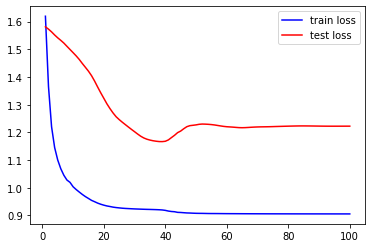

In [20]:
model, train_losses, test_losses = train_model(model, x_train, y_train, x_test, y_test, criterion,  num_epoch=100)
draw_loss(train_losses, test_losses)

In [21]:
def evaluate(model, x_test, y_test, show_progress=True):
    
    hit_matrix = np.zeros((5,5))
    
    model.eval()
    hit = 0
    for i in range(len(x_test)):
        outputs = model(x_test[i].view(1,-1))    # MLP 네트워크의 output
        confidence, predicted = torch.max(outputs, 1)
        #print(y_test[i])
        _, actual = torch.max(y_test[i].view(1,-1), 1)

        if show_progress:
            print(f"Predicted: {predicted.item()} ({confidence.item():.2f}), "\
                  f"actual: {actual.item()} / {predicted.item()==actual.item()}")

        if predicted[0].item() == actual[0].item():
            hit += 1

        hit_matrix[predicted.item()][actual.item()] += 1

    print(f"accuray: {hit/len(x_test)*100:.2f}% ({hit}/{len(x_test)})")
    
    return hit_matrix


In [22]:
hit_matrix = evaluate(model, x_test, y_test)

Predicted: 2 (0.84), actual: 2 / True
Predicted: 2 (0.98), actual: 2 / True
Predicted: 2 (1.00), actual: 2 / True
Predicted: 1 (0.84), actual: 1 / True
Predicted: 1 (0.96), actual: 1 / True
Predicted: 1 (0.75), actual: 1 / True
Predicted: 0 (0.97), actual: 0 / True
Predicted: 0 (1.00), actual: 0 / True
Predicted: 1 (0.50), actual: 0 / False
Predicted: 0 (1.00), actual: 0 / True
Predicted: 0 (0.99), actual: 0 / True
Predicted: 1 (0.98), actual: 1 / True
Predicted: 0 (0.51), actual: 1 / False
Predicted: 3 (0.86), actual: 2 / False
Predicted: 3 (1.00), actual: 2 / False
Predicted: 3 (0.96), actual: 3 / True
Predicted: 3 (1.00), actual: 3 / True
Predicted: 3 (0.98), actual: 4 / False
Predicted: 4 (1.00), actual: 4 / True
Predicted: 4 (1.00), actual: 4 / True
Predicted: 4 (0.99), actual: 4 / True
Predicted: 3 (0.51), actual: 4 / False
Predicted: 3 (0.98), actual: 3 / True
Predicted: 2 (0.98), actual: 3 / False
Predicted: 2 (1.00), actual: 2 / True
Predicted: 2 (0.96), actual: 2 / True
Predi

In [23]:
print(hit_matrix)

[[5. 1. 0. 0. 0.]
 [2. 4. 0. 0. 0.]
 [1. 0. 5. 1. 0.]
 [0. 2. 2. 3. 2.]
 [0. 0. 0. 0. 3.]]


In [24]:
def draw_heatmap(hit_matrix):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns

    map_df = pd.DataFrame(hit_matrix.astype(int))
    map_df = map_df.iloc[::-1]  # row 순서 바꾸기
    # heatmap

    ax = plt.axes()

    ax = sns.heatmap(map_df,
                     ax=ax,
                     cmap="Blues",           # cmap Color
                     annot=True,            # Value Text
                     fmt="d",             # Value type (interge = "d")
                     linewidths=2)  
    plt.xlabel('Predict', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.show()


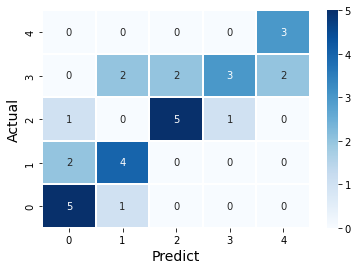

In [25]:
draw_heatmap(hit_matrix)

# 모델 생성 및 시뮬레이션을 위하여 필요한 부분만 발췌

- learning rate를 0.1, 0.01, 0.001 로 변경해가면서 실험
- 모델의 레이어를 변경해가면서 실험

In [26]:
class MLP(nn.Module):
        
    def __init__(self, in_features, out_features):
        super(MLP, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Linear(in_features, 128),    # layer1 - input
            nn.ReLU(),              
            nn.BatchNorm1d(128), 
            nn.Linear(128, 256),            # layer2 - hidden
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 256),            # layer3 - hidden
            nn.ReLU(),
            nn.BatchNorm1d(256),

            #nn.Linear(256, 256),            # layer block - hidden
            #nn.ReLU(),
            #nn.BatchNorm1d(256),

            #nn.Linear(256, 256),            # layer block - hidden
            #nn.ReLU(),
            #nn.BatchNorm1d(256),
            
            #nn.Linear(256, 256),            # layer block - hidden
            #nn.ReLU(),
            #nn.BatchNorm1d(256),
            
            nn.Linear(256, 128),            # layer4 - hidden
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, out_features),    # layer5 - out
        )
        
    def forward(self, x):
        out = self.nn(x)
        out = F.softmax(out, dim=1)
        
        return out
        

In [32]:
model = MLP(25, 5).to(device)
acc_train_loss = []
acc_test_loss = []

[0100], train_loss:1.3353409767, test_loss:1.2918430567 duration: 0.8s
[0200], train_loss:1.4395511150, test_loss:1.6932833195 duration: 1.1s
[0300], train_loss:1.4742771387, test_loss:1.4850425720 duration: 0.7s
[0400], train_loss:1.4742771387, test_loss:1.4212688208 duration: 1.0s
[0500], train_loss:1.4312222004, test_loss:1.4532195330 duration: 0.7s
[0600], train_loss:1.5298324823, test_loss:1.5822517872 duration: 0.7s
[0700], train_loss:1.5298326015, test_loss:1.5177420378 duration: 0.7s
[0800], train_loss:1.5298326015, test_loss:1.5177358389 duration: 0.9s
[0900], train_loss:1.5298326015, test_loss:1.5177358389 duration: 1.4s
[1000], train_loss:1.5298326015, test_loss:1.5177358389 duration: 1.3s


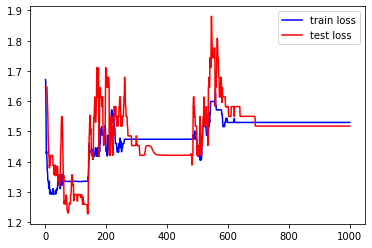

accuray: 38.71% (12/31)


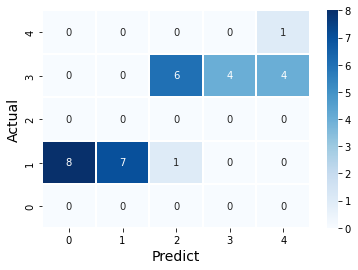

In [33]:
model, train_loss, test_loss = train_model(model, x_train, y_train, x_test, y_test, criterion, lr=0.1, num_epoch=1000)

acc_train_loss.extend(train_loss)
acc_test_loss.extend(test_loss)
#draw_loss(train_loss, test_loss)
draw_loss(acc_train_loss, acc_test_loss)

hit_matrix = evaluate(model, x_test, y_test, show_progress=False)
draw_heatmap(hit_matrix)